## Proposed - 1 -  Sigma_q with Identity and Load input state in env state

In [1]:
import sys, os
sys.path.append(os.path.abspath('../../classifiers'))
sys.path.append(os.path.abspath('../../training'))
sys.path.append(os.path.abspath('../../validation'))
from validation_functions import execute_training_test_k_fold
from classifiers_ICQ import iqc_classifier

from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import normalize
import numpy as np
import matplotlib.pyplot as plt

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
if 'normalize_axis' not in locals() and 'normalize_axis' not in globals():
    normalize_axis = 0
if 'load_inputvector_env_state' not in locals() and 'load_inputvector_env_state' not in globals():
    load_inputvector_env_state = False
if 'use_exponential_on_input' not in locals() and 'use_exponential_on_input' not in globals():
    use_exponential_on_input = False
dataset_name = "linear_sep.npy"

In [3]:
def get_dataset():
    path_to_datasets = "../../datasets/Datasets_template_exp/" 
    dataset = np.load(path_to_datasets + dataset_name)

    X, y = dataset[:,:-1],dataset[:,-1]

    X_copy = X.copy()
    X_copy = normalize(X_copy, axis=normalize_axis)

    if use_exponential_on_input:
        X_copy = np.exp(X_copy)

    X0 = np.exp(X_copy[y == 0])
    X1 = np.exp(X_copy[y == 1])

    plt.plot(X0[:,0],X0[:,1],'o')
    plt.plot(X1[:,0],X1[:,1],'o')
    plt.title(dataset_name)
    return X, y

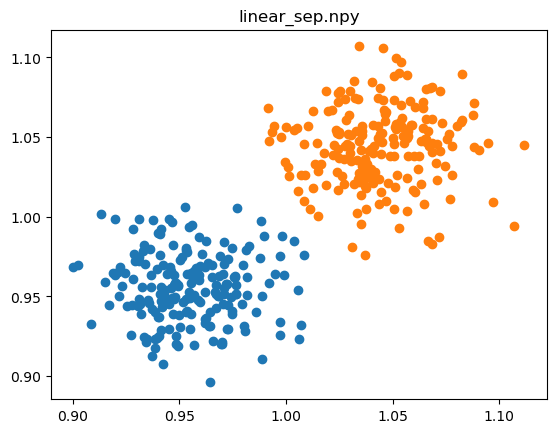

In [4]:
X, y = get_dataset()
classifier_function = iqc_classifier
dic_classifier_params = {}
dic_classifier_params["sigma_q_params"] = [1,1,1,1]
dic_classifier_params["use_polar_coordinates_on_sigma_q"] = False
dic_classifier_params["load_inputvector_env_state"] = load_inputvector_env_state
dic_classifier_params["normalize_axis"] = normalize_axis
dic_classifier_params["use_exponential_on_input"] = use_exponential_on_input

dic_training_params = {"max_iter": 1000,
    "accuracy_succ": 0.99,
    "plot_graphs_and_metrics": False,
    "plot_graphs_in_classifier": False,
    "random_seed": 1,
    "learning_rate": 0.01,
    "refit_db":True,
    "reset_weights_epoch":0,
    "do_classes_refit":True,
    "batch":False}

n_times_kfold = 20
k_times_fold = 10

In [ ]:
%%time
scores_list = []
f1scores_list = []
negativities_list = []
for SEED in range(n_times_kfold):
    scores, f1scores, output_dict = execute_training_test_k_fold(
                    X, 
                    y, 
                    k_folds=k_times_fold,
                    random_seed = SEED, 
                    classifier_function=classifier_function, 
                    dic_classifier_params=dic_classifier_params,
                    one_vs_classifier=OneVsRestClassifier, 
                    dic_training_params=dic_training_params,
                    print_each_fold_metric=True,
                    print_avg_metric=True)
    scores_list.append(scores)
    f1scores_list.append(f1scores)
    negativities_list.append(output_dict["negativities"])

In [ ]:
print("Media Score dos N K-Fold", np.mean([np.mean(i) for i in scores_list]))
print("Maior Score dos K-Fold", max([np.mean(i) for i in scores_list]))
print("Menor Score dos K-Fold", min([np.mean(i) for i in scores_list]))

print()
print()
print(scores_list)

In [ ]:
print("Media F1Score dos N K-Fold", np.mean([np.mean(i) for i in f1scores_list]))
print("Maior F1Score dos K-Fold", max([np.mean(i) for i in f1scores_list]))
print("Menor F1Score dos K-Fold", min([np.mean(i) for i in f1scores_list]))

print()
print()
print(f1scores_list)

In [ ]:
print("Media Negativity dos N K-Fold", np.mean([neg for neg in negativities_list]))

print()
print()
print(negativities_list)

In [ ]:
path = "results/"
if load_inputvector_env_state:
    path = path + "proposed/"
else:
    path = path + "original/"
path = path + "norm-" + str(normalize_axis) + "/"

if not os.path.exists(path):
    os.makedirs(path)

In [ ]:
with open(path + dataset_name + ".txt", "w") as file:
    data = """Scores dos dos N K-Fold: %s
        Média Scores dos K-Fold: %.4f
        Maior Score dos K-Fold: %.4f
        Menor Score dos K-Fold: %.4f
    F1-Scores: %s
        Média F1-Scores dos K-Fold: %.4f
        Maior F1-Score dos K-Fold: %.4f
        Menor F1-Score dos K-Fold: %.4f
    Negativities: %s
        Média Negativities dos K-Fold: %.4f
    """ % (str(scores_list), 
               np.mean([np.mean(i) for i in scores_list]),
               max([np.mean(i) for i in scores_list]),
               min([np.mean(i) for i in scores_list]),
               str(f1scores_list),
               np.mean([np.mean(i) for i in f1scores_list]),
               max([np.mean(i) for i in f1scores_list]),
               min([np.mean(i) for i in f1scores_list]),
               str(negativities_list),
               np.mean([neg for neg in negativities_list]))
    
    file.write(data)